In [ ]:
# =========================
# CELL V0 — Colab: mount Google Drive + paths
# =========================
from google.colab import drive
drive.mount('/content/drive')

import os

# --- Project root on Drive (from your screenshot) ---
DRIVE_ROOT = "/content/drive/MyDrive/iris_project"

# --- Data ---
JSON_PATH = os.path.join(DRIVE_ROOT, "annotations_6d_casia_v3_interval.json")
IMG_ROOT  = os.path.join(DRIVE_ROOT, "CASIA_V3_Interval_images")

# --- Checkpoints ---
ILN_CKPT = os.path.join(DRIVE_ROOT, "checkpoints_iln", "iln_best_val.pth")
PRN_CKPT = os.path.join(DRIVE_ROOT, "checkpoints_prn", "prn_best_val.pth")

# Optional cache (if you have it, otherwise leave None)
ILN_CACHE = os.path.join(DRIVE_ROOT, "cache", "iln_pred_by_fn.npy")
if not os.path.exists(ILN_CACHE):
    ILN_CACHE = None

# --- Outputs (persist on Drive) ---
OUT_DIR = os.path.join(DRIVE_ROOT, "verification_daugman")
os.makedirs(OUT_DIR, exist_ok=True)

print("DRIVE_ROOT:", DRIVE_ROOT)
print("JSON_PATH :", JSON_PATH)
print("IMG_ROOT  :", IMG_ROOT)
print("ILN_CKPT  :", ILN_CKPT)
print("PRN_CKPT  :", PRN_CKPT)
print("ILN_CACHE :", ILN_CACHE)
print("OUT_DIR   :", OUT_DIR)

missing = []
if not os.path.exists(JSON_PATH): missing.append("annotations_6d_casia_v3_interval.json")
if not os.path.isdir(IMG_ROOT):   missing.append("CASIA_V3_Interval_images/ (folder)")
if not os.path.exists(ILN_CKPT):  missing.append("checkpoints_iln/iln_best_val.pth")
if not os.path.exists(PRN_CKPT):  missing.append("checkpoints_prn/prn_best_val.pth")
if missing:
    raise FileNotFoundError(
        "Missing required files under DRIVE_ROOT:\n"
        + "\n".join(" - " + m for m in missing)
        + "\n\n👉 Fix: check the folder names in Drive match exactly your screenshot."
    )


Mounted at /content/drive
DRIVE_ROOT: /content/drive/MyDrive/iris_project
JSON_PATH : /content/drive/MyDrive/iris_project/annotations_6d_casia_v3_interval.json
IMG_ROOT  : /content/drive/MyDrive/iris_project/CASIA_V3_Interval_images
ILN_CKPT  : /content/drive/MyDrive/iris_project/checkpoints_iln/iln_best_val.pth
PRN_CKPT  : /content/drive/MyDrive/iris_project/checkpoints_prn/prn_best_val.pth
ILN_CACHE : /content/drive/MyDrive/iris_project/cache/iln_pred_by_fn.npy
OUT_DIR   : /content/drive/MyDrive/iris_project/verification_daugman


In [ ]:
# =========================
# CELL V1 — imports + device + constants
# =========================
import os, json, math, random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

# Repro (optional)
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Image geometry (must match training)
IMG_W, IMG_H = 640, 480

# PRN ROI
ROI_SIZE = 128

# Daugman normalization grid
RADIAL_RES = 64    # rows
ANG_RES    = 512   # cols

print("IMG:", (IMG_H, IMG_W), "| ROI_SIZE:", ROI_SIZE, "| norm:", (RADIAL_RES, ANG_RES))


device: cuda
IMG: (480, 640) | ROI_SIZE: 128 | norm: (64, 512)


Load CASIA annotations and resolve Drive image paths

Loads the JSON annotations, indexes all images under IMG_ROOT, and resolve each image_path to build valid training samples.
 The cell reports missing files and basic subject/eye statistics to ensure the dataset is correctly assembled in Colab/Drive.

In [ ]:
# =========================
# CELL V2 — load annotations (CASIA JSON) + build samples  [COLAB PATHS]
# =========================
import json, os, glob
from collections import Counter

print("JSON_PATH:", JSON_PATH)
print("IMG_ROOT :", IMG_ROOT)

if not os.path.isdir(IMG_ROOT):
    raise FileNotFoundError("Images folder not found: " + str(IMG_ROOT))

# 1) index all images by basename (fast + robust)
img_index = {}
for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
    for p in glob.glob(os.path.join(IMG_ROOT, "**", ext), recursive=True):
        img_index[os.path.basename(p)] = p

print("Indexed images:", len(img_index))
if len(img_index) == 0:
    raise FileNotFoundError("No images found under IMG_ROOT: " + str(IMG_ROOT))

def resolve_img_path(p):
    """Resolve JSON path to an existing path on Drive (via basename lookup)."""
    if p is None:
        return None
    p = str(p)

    # if it already exists as-is, keep it
    if os.path.exists(p):
        return p

    # otherwise fallback to basename lookup inside IMG_ROOT
    base = os.path.basename(p)
    return img_index.get(base, None)

# 2) load json
with open(JSON_PATH, "r") as f:
    ann = json.load(f)

records = ann["annotations"]

samples = []
missing = 0
missing_examples = []

for it in records:
    raw_path = it.get("image_path", None)
    img_path = resolve_img_path(raw_path)

    if img_path is None or (not os.path.exists(img_path)):
        missing += 1
        if len(missing_examples) < 10:
            missing_examples.append(raw_path)
        continue

    sid_raw = it["id"]               # e.g. S1001L01
    subject = sid_raw[:5]            # S1001
    eye     = sid_raw[5]             # L/R
    idx     = sid_raw[6:]            # 01, 02, ...

    sid = f"{subject}_{eye}"         # e.g. S1001_L

    samples.append({
        "id": sid_raw,
        "sid": sid,
        "subject": subject,
        "eye": eye,
        "idx": idx,
        "image_path": img_path,
        "filename": os.path.basename(img_path),
        "pupil_gt": it["pupil"],
        "iris_gt": it["iris"],
    })

cnt = Counter([s["sid"] for s in samples])
print("\nUsable samples:", len(samples))
print("Missing images:", missing)
print("IDs (subject_eye):", len(cnt))
print("IDs (>=2 imgs):", sum(1 for v in cnt.values() if v >= 2))
print("Top-10 IDs:", cnt.most_common(10))

if missing_examples:
    print("\nMissing examples (raw JSON paths):")
    for p in missing_examples[:10]:
        print(" -", p)

print("\nExample first 10 resolved:")
for s in samples[:10]:
    print(s["id"], "->", s["sid"], "| file:", s["filename"])


JSON_PATH: /content/drive/MyDrive/iris_project/annotations_6d_casia_v3_interval.json
IMG_ROOT : /content/drive/MyDrive/iris_project/CASIA_V3_Interval_images
Indexed images: 2639

Usable samples: 2636
Missing images: 0
IDs (subject_eye): 395
IDs (>=2 imgs): 372
Top-10 IDs: [('S1019_R', 26), ('S1211_L', 15), ('S1218_R', 15), ('S1019_L', 14), ('S1053_L', 13), ('S1028_L', 12), ('S1045_L', 11), ('S1224_R', 11), ('S1001_L', 10), ('S1001_R', 10)]

Example first 10 resolved:
S1001L01 -> S1001_L | file: S1001L01.jpg
S1001L02 -> S1001_L | file: S1001L02.jpg
S1001L03 -> S1001_L | file: S1001L03.jpg
S1001L04 -> S1001_L | file: S1001L04.jpg
S1001L05 -> S1001_L | file: S1001L05.jpg
S1001L06 -> S1001_L | file: S1001L06.jpg
S1001L07 -> S1001_L | file: S1001L07.jpg
S1001L08 -> S1001_L | file: S1001L08.jpg
S1001L09 -> S1001_L | file: S1001L09.jpg
S1001L10 -> S1001_L | file: S1001L10.jpg


In [ ]:
# =========================
# CELL V3 — dataset images-only + preprocess (1x480x640)
# =========================
from torch.utils.data import Dataset, DataLoader
import os

def preprocess_full_pil(img_pil, out_w=IMG_W, out_h=IMG_H):
    """
    PIL -> torch tensor (1,out_h,out_w) in [0,1]
    """
    img = img_pil.convert("L").resize((out_w, out_h), Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0          # (H,W)
    x = torch.from_numpy(arr).unsqueeze(0)                 # (1,H,W)
    return x

class IrisImagesOnlyDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        img_path = s["image_path"]
        img = Image.open(img_path)
        x = preprocess_full_pil(img)  # (1,480,640)

        # filename robusto: se non esiste nel dict, lo ricaviamo dal path
        filename = s.get("filename", os.path.basename(img_path))

        return {
            "image": x,
            "sid": s["sid"],
            "filename": filename,
            "image_path": img_path,
        }

# build dataset + loader (no shuffle for reproducibility; we can shuffle later if needed)
ver_ds = IrisImagesOnlyDataset(samples)
pin = torch.cuda.is_available()

VER_BATCH = 16
ver_loader = DataLoader(ver_ds, batch_size=VER_BATCH, shuffle=False, num_workers=2, pin_memory=pin)

# sanity
b = next(iter(ver_loader))
print("batch keys:", b.keys())
print("image:", b["image"].shape, b["image"].dtype, "min/max:",
      float(b["image"].min()), float(b["image"].max()))
print("sid[0]:", b["sid"][0], "| filename[0]:", b["filename"][0], "| path[0]:", b["image_path"][0])


batch keys: dict_keys(['image', 'sid', 'filename', 'image_path'])
image: torch.Size([16, 1, 480, 640]) torch.float32 min/max: 0.0941176488995552 1.0
sid[0]: S1001_L | filename[0]: S1001L01.jpg | path[0]: /content/drive/MyDrive/iris_project/CASIA_V3_Interval_images/001/L/S1001L01.jpg


Models and ROI utilities and checkpoint loading

Re-declare ILN/PRN architectures and the ROI-building logic as used during training.
 The cell then loads the saved checkpoints and runs a quick sanity forward pass to verify output shapes and end-to-end ILN→ROI→PRN execution.

In [ ]:
# =========================
# CELL V4 — Model defs + denormalize_iln + ROI builder (MATCH TRAINING) + load ckpts (FIXED)
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

# -------------------------
# ConvBNReLU + ILNNet (YOUR TRAINING VERSION)
# -------------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ILNNet(nn.Module):
    """
    Input:  (B, 1, 480, 640)
    Output: (B, 6) normalized [xp, yp, rp, xi, yi, ri]
    """
    def __init__(self, in_ch=1, out_dim=6, width=32):
        super().__init__()
        self.stem = nn.Sequential(
            ConvBNReLU(in_ch, width, 3, 2, 1),
            ConvBNReLU(width, width, 3, 1, 1)
        )
        self.features = nn.Sequential(
            ConvBNReLU(width,   width*2, 3, 2, 1),
            ConvBNReLU(width*2, width*2, 3, 1, 1),

            ConvBNReLU(width*2, width*4, 3, 2, 1),
            ConvBNReLU(width*4, width*4, 3, 1, 1),

            ConvBNReLU(width*4, width*8, 3, 2, 1),
            ConvBNReLU(width*8, width*8, 3, 1, 1),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(width*8, width*8),
            nn.ReLU(inplace=True),
            nn.Linear(width*8, out_dim)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.gap(x)
        return self.head(x)

# -------------------------
# PRNNet (YOUR TRAINING VERSION)
# -------------------------
class PRNNet(nn.Module):
    """
    Input:  (B,1,128,128)
    Output: (B,3) normalized in ROI space [x/128, y/128, r/128]
    """
    def __init__(self, in_ch=1, width=16, out_dim=3):
        super().__init__()
        self.features = nn.Sequential(
            ConvBNReLU(in_ch, width, 3, 2, 1),      # 128 -> 64
            ConvBNReLU(width, width, 3, 1, 1),

            ConvBNReLU(width, width*2, 3, 2, 1),    # 64 -> 32
            ConvBNReLU(width*2, width*2, 3, 1, 1),

            ConvBNReLU(width*2, width*4, 3, 2, 1),  # 32 -> 16
            ConvBNReLU(width*4, width*4, 3, 1, 1),

            ConvBNReLU(width*4, width*8, 3, 2, 1),  # 16 -> 8
            ConvBNReLU(width*8, width*8, 3, 1, 1),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(width*8, width*8),
            nn.ReLU(inplace=True),
            nn.Linear(width*8, out_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        return self.head(x)

# -------------------------
# denormalize_iln (MATCH TRAINING)
# y_norm: (...,6) in [xp/W, yp/H, rp/W, xi/W, yi/H, ri/W]
# -------------------------
@torch.no_grad()
def denormalize_iln(y_norm: torch.Tensor, W=IMG_W, H=IMG_H) -> torch.Tensor:
    y = y_norm.clone()
    y[..., 0] = y[..., 0] * W
    y[..., 1] = y[..., 1] * H
    y[..., 2] = y[..., 2] * W
    y[..., 3] = y[..., 3] * W
    y[..., 4] = y[..., 4] * H
    y[..., 5] = y[..., 5] * W
    return y

# -------------------------
# ROI utils (MATCH TRAINING)
# -------------------------
def clamp(v, lo, hi):
    return max(lo, min(hi, v))

def crop_roi_around_center(img_1xHxW: torch.Tensor,
                           center_xy: Tuple[float, float],
                           roi_side: int):
    """
    Crops with boundary clamping (no padding), exactly like training.
    Returns roi and (x0,y0,x1,y1) in original coords.
    """
    _, H, W = img_1xHxW.shape
    cx, cy = center_xy

    half = roi_side / 2.0
    x0 = int(round(cx - half))
    y0 = int(round(cy - half))
    x1 = x0 + roi_side
    y1 = y0 + roi_side

    x0_c = clamp(x0, 0, W - roi_side)
    y0_c = clamp(y0, 0, H - roi_side)
    x1_c = x0_c + roi_side
    y1_c = y0_c + roi_side

    roi = img_1xHxW[:, y0_c:y1_c, x0_c:x1_c]
    return roi, (x0_c, y0_c, x1_c, y1_c)

def build_prn_sample(full_img_1x480x640: torch.Tensor,
                     pupil_px: Tuple[float, float, float],
                     roi_center_px: Tuple[float, float],
                     roi_scale: float = 4.0,
                     out_size: int = ROI_SIZE):
    """
    MATCH TRAINING:
      roi_side_full = roi_scale * rp
      crop is clamped to image bounds
      resize to out_size
      meta has roi_box_full + scale_full_to_out
    """
    xp, yp, rp = map(float, pupil_px)
    cx, cy = map(float, roi_center_px)

    roi_side = int(round(max(16.0, roi_scale * rp)))
    if roi_side % 2 == 1:
        roi_side += 1

    roi_full, (x0, y0, x1, y1) = crop_roi_around_center(full_img_1x480x640, (cx, cy), roi_side)

    roi_out = F.interpolate(
        roi_full.unsqueeze(0),
        size=(out_size, out_size),
        mode="bilinear",
        align_corners=False
    ).squeeze(0)

    xp_roi = xp - x0
    yp_roi = yp - y0
    sx = out_size / roi_side

    xp_out = xp_roi * sx
    yp_out = yp_roi * sx
    rp_out = rp * sx

    y_prn = torch.tensor([xp_out/out_size, yp_out/out_size, rp_out/out_size], dtype=torch.float32)

    meta = {
        "roi_side_full": roi_side,
        "roi_box_full": (x0, y0, x1, y1),
        "scale_full_to_out": float(sx),
        "roi_center_full": (cx, cy),
    }
    return roi_out, y_prn, meta

# -------------------------
# Load checkpoints (FIXED for your wrapper format)
# -------------------------
def _clean_state_dict(sd):
    if not isinstance(sd, dict):
        return sd
    out = {}
    for k, v in sd.items():
        out[k.replace("module.", "")] = v
    return out

def load_ckpt(model, path, name="model"):
    ckpt = torch.load(path, map_location=device)

    # 1) your wrapper format
    if isinstance(ckpt, dict) and ("model_state" in ckpt):
        sd = ckpt["model_state"]
        print(f"[{name}] ckpt wrapper detected | epoch={ckpt.get('epoch', None)} | best_val={ckpt.get('best_val', None)}")

    # 2) other common wrappers
    elif isinstance(ckpt, dict) and ("model" in ckpt):
        sd = ckpt["model"]
        print(f"[{name}] ckpt dict with key 'model' detected")

    elif isinstance(ckpt, dict) and ("state_dict" in ckpt):
        sd = ckpt["state_dict"]
        print(f"[{name}] ckpt dict with key 'state_dict' detected")

    # 3) already a state_dict
    else:
        sd = ckpt
        print(f"[{name}] plain state_dict detected")

    model.load_state_dict(_clean_state_dict(sd), strict=True)
    return ckpt

# instantiate
model_iln = ILNNet(in_ch=1, out_dim=6, width=32).to(device)
model_prn = PRNNet(in_ch=1, width=16, out_dim=3).to(device)

# load
load_ckpt(model_iln, ILN_CKPT, name="ILN")
load_ckpt(model_prn, PRN_CKPT, name="PRN")

model_iln.eval()
model_prn.eval()

print("✅ Loaded ILN:", ILN_CKPT)
print("✅ Loaded PRN:", PRN_CKPT)

# -------------------------
# Sanity forward
# -------------------------
b = next(iter(ver_loader))
x = b["image"].to(device)  # (B,1,480,640)
with torch.no_grad():
    y_hat = model_iln(x)
print("ILN out:", y_hat.shape)

with torch.no_grad():
    y0_px = denormalize_iln(y_hat[0:1]).squeeze(0)  # (6,)
    xp_c, yp_c, rp_c = [float(v) for v in y0_px[0:3]]

    roi_img, _, meta = build_prn_sample(
        full_img_1x480x640=x[0].detach().cpu(),
        pupil_px=(xp_c, yp_c, rp_c),
        roi_center_px=(xp_c, yp_c),
        roi_scale=4.0,
        out_size=ROI_SIZE
    )

    roi_in = roi_img.unsqueeze(0).to(device)     # (1,1,128,128)
    y_prn = model_prn(roi_in).squeeze(0).cpu()   # (3,)

print("PRN out (single):", y_prn.shape, " | sid/file:", b["sid"][0], b["filename"][0])


[ILN] ckpt wrapper detected | epoch=9 | best_val=0.028646098732045204
[PRN] ckpt wrapper detected | epoch=8 | best_val=0.00878111490358909
✅ Loaded ILN: /content/drive/MyDrive/iris_project/checkpoints_iln/iln_best_val.pth
✅ Loaded PRN: /content/drive/MyDrive/iris_project/checkpoints_prn/prn_best_val.pth
ILN out: torch.Size([16, 6])
PRN out (single): torch.Size([3])  | sid/file: S1001_L S1001L01.jpg


In [ ]:
# =========================
# CELL V5 — batch inference (ILN + PRN) -> circles in FULL px
# =========================
import numpy as np
import torch

@torch.no_grad()
def prn_to_full(pupil_prn_norm, meta):
    """
    pupil_prn_norm: (3,) normalized in ROI [0,1]
    meta: dict with roi_box_full and scale_full_to_out
    returns (xp,yp,rp) in FULL px
    """
    x0, y0, x1, y1 = meta["roi_box_full"]
    sx = float(meta["scale_full_to_out"])  # out / roi_side_full

    xp_roi = float(pupil_prn_norm[0] * ROI_SIZE)
    yp_roi = float(pupil_prn_norm[1] * ROI_SIZE)
    rp_roi = float(pupil_prn_norm[2] * ROI_SIZE)

    xp_full = float(x0) + xp_roi / sx
    yp_full = float(y0) + yp_roi / sx
    rp_full = rp_roi / sx
    return xp_full, yp_full, rp_full


@torch.no_grad()
def infer_batch_circles(model_iln, model_prn, batch, roi_scale=4.0):
    """
    batch: from ver_loader -> keys: image (B,1,480,640), sid (list), filename (list)
    returns list of dicts, one per sample:
      {
        sid, filename,
        pupil_refined: (xp,yp,rp),
        iris:          (xi,yi,ri),
        pupil_coarse:  (xp,yp,rp)
      }
    """
    model_iln.eval()
    model_prn.eval()

    x_full = batch["image"].to(device, non_blocking=True)  # (B,1,480,640)
    sids   = batch["sid"]
    names  = batch["filename"]

    # ILN forward
    y_hat = model_iln(x_full)                      # (B,6) normalized
    y_px  = denormalize_iln(y_hat).detach().cpu()  # (B,6) full px

    out = []
    B = x_full.shape[0]

    for i in range(B):
        xp_c, yp_c, rp_c, xi, yi, ri = [float(v) for v in y_px[i].tolist()]

        # ROI on ILN pupil
        roi_img, _dummy, meta = build_prn_sample(
            full_img_1x480x640=x_full[i].detach().cpu(),
            pupil_px=(xp_c, yp_c, rp_c),
            roi_center_px=(xp_c, yp_c),
            roi_scale=roi_scale,
            out_size=ROI_SIZE
        )

        roi_in = roi_img.unsqueeze(0).to(device)              # (1,1,128,128)
        y_prn_hat = model_prn(roi_in).squeeze(0).detach().cpu()  # (3,)

        xp_r, yp_r, rp_r = prn_to_full(y_prn_hat, meta)

        out.append({
            "sid": sids[i],
            "filename": names[i],
            "pupil_refined": (xp_r, yp_r, rp_r),
            "iris": (xi, yi, ri),
            "pupil_coarse": (xp_c, yp_c, rp_c),
        })

    return out


# --- quick sanity on one batch ---
b = next(iter(ver_loader))
preds = infer_batch_circles(model_iln, model_prn, b, roi_scale=4.0)

print("Got preds:", len(preds))
for j in range(min(2, len(preds))):
    print(preds[j]["sid"], preds[j]["filename"])
    print("  pupil_refined:", preds[j]["pupil_refined"])
    print("  iris:", preds[j]["iris"])


Got preds: 16
S1001_L S1001L01.jpg
  pupil_refined: (310.4529333114624, 194.4355410337448, 104.39637172222136)
  iris: (326.141845703125, 246.10731506347656, 173.079833984375)
S1001_L S1001L02.jpg
  pupil_refined: (322.2640326023102, 219.84851002693176, 92.76445978879929)
  iris: (328.3858642578125, 230.56565856933594, 178.09571838378906)


Rubber-sheet normalization with iris shrink (β)

A robust “rubber sheet” is implemented by sampling along rays from the pupil center: the inner boundary is the pupil circle, while the outer boundary is the ray–iris intersection scaled by a shrink factor beta_iris to avoid noisy iris/eyelid regions.

In [ ]:
# =========================
# CELL V6c — Rubber Sheet (ray+intersection) with IRIS SHRINK factor beta
# =========================
import numpy as np

def _bilinear_sample(img, xs, ys):
    H, W = img.shape
    xs = np.clip(xs, 0, W - 1)
    ys = np.clip(ys, 0, H - 1)

    x0 = np.floor(xs).astype(np.int32)
    y0 = np.floor(ys).astype(np.int32)
    x1 = np.clip(x0 + 1, 0, W - 1)
    y1 = np.clip(y0 + 1, 0, H - 1)

    wa = (x1 - xs) * (y1 - ys)
    wb = (xs - x0) * (y1 - ys)
    wc = (x1 - xs) * (ys - y0)
    wd = (xs - x0) * (ys - y0)

    Ia = img[y0, x0]
    Ib = img[y0, x1]
    Ic = img[y1, x0]
    Id = img[y1, x1]
    return (wa*Ia + wb*Ib + wc*Ic + wd*Id).astype(np.float32)


def rubber_sheet_normalize_ray(img_1xHxW_torch, pupil, iris,
                               radial_res=RADIAL_RES, ang_res=ANG_RES,
                               r_min=0.08, r_max=0.92,
                               beta_iris=0.85):

    img = img_1xHxW_torch.squeeze(0).detach().cpu().numpy().astype(np.float32)
    H, W = img.shape

    xp, yp, rp = map(float, pupil)
    xi, yi, ri = map(float, iris)

    theta = np.linspace(0, 2*np.pi, ang_res, endpoint=False).astype(np.float32)
    dx = np.cos(theta); dy = np.sin(theta)

    # inner boundary: pupil circle along ray
    x_p = xp + rp * dx
    y_p = yp + rp * dy

    # outer boundary: intersection of ray with iris circle
    ox = xp - xi
    oy = yp - yi
    b = ox*dx + oy*dy
    c = ox*ox + oy*oy - ri*ri
    disc = np.maximum(b*b - c, 0.0)
    t = -b + np.sqrt(disc)  # distance along ray to the circle

    # ---- SHRINK HERE ----
    t = beta_iris * t

    x_i = xp + t * dx
    y_i = yp + t * dy

    r = np.linspace(r_min, r_max, radial_res).astype(np.float32)[:, None]  # (R,1)
    xs = (1 - r) * x_p[None, :] + r * x_i[None, :]
    ys = (1 - r) * y_p[None, :] + r * y_i[None, :]

    norm = _bilinear_sample(img, xs, ys)
    return norm, xs, ys


Segmentation-free adaptive masking with per-column IQR rejection

The validity mask is built directly in the normalized iris strip by:
(i) removing top/bottom bands as an eyelid proxy
(ii) masking extreme highlights/shadows via capped percentiles
(iii) suppressing outliers using an IQR rule per angular column.
The resulting mask and valid_ratio support stable IrisCode extraction without explicit eyelid landmarks.

In [ ]:
# =========================
# CELL V7 — Adaptive mask (segmentation-free) + IQR per-column (IMPROVED)
# =========================
import numpy as np

def build_mask_norm_adaptive(norm,
                             top_frac=0.12,
                             bot_frac=0.12,
                             hi_q=99.0,          # percentile for highlights (more conservative)
                             lo_q=1.0,           # percentile for dark occlusions
                             hi_cap=0.985,       # cap on hi threshold to avoid "almost no masking"
                             lo_cap=0.15,        # cap on lo threshold to avoid over-masking
                             use_iqr=True,
                             iqr_k=1.5,          # IQR outlier strength (1.5 typical)
                             iqr_axis="col",     # "col" (theta-wise) or "global"
                             use_texture=False,
                             texture_win=7,
                             texture_min=0.005):

    R, A = norm.shape
    mask = np.ones((R, A), dtype=np.uint8)

    # (1) eyelids proxy: remove top/bottom bands (no P1..P8)
    t = int(round(top_frac * R))
    b = int(round(bot_frac * R))
    if t > 0:
        mask[:t, :] = 0
    if b > 0:
        mask[R-b:, :] = 0

    # (2) robust thresholds from percentiles + caps
    hi_thresh = float(np.percentile(norm, hi_q))
    lo_thresh = float(np.percentile(norm, lo_q))

    hi_thresh = min(hi_thresh, float(hi_cap))
    lo_thresh = min(lo_thresh, float(lo_cap))

    # apply thresholds
    mask[norm >= hi_thresh] = 0
    mask[norm <= lo_thresh] = 0

    # (3) IQR outlier masking (paper-like spirit): remove outliers per-theta column
    if use_iqr:
        if iqr_axis == "col":
            q1 = np.quantile(norm, 0.25, axis=0)  # (A,)
            q3 = np.quantile(norm, 0.75, axis=0)  # (A,)
            iqr = (q3 - q1) + 1e-6
            low_thr = q1 - float(iqr_k) * iqr
            high_thr = q3 + float(iqr_k) * iqr
            out = (norm < low_thr[None, :]) | (norm > high_thr[None, :])
            mask[out] = 0
        else:
            q1 = float(np.quantile(norm, 0.25))
            q3 = float(np.quantile(norm, 0.75))
            iqr = (q3 - q1) + 1e-6
            low_thr = q1 - float(iqr_k) * iqr
            high_thr = q3 + float(iqr_k) * iqr
            out = (norm < low_thr) | (norm > high_thr)
            mask[out] = 0

    # (4) optional texture rejection (keep off unless needed)
    if use_texture and texture_win >= 3:
        k = int(texture_win)
        if k % 2 == 0:
            k += 1
        pad = k // 2
        x = np.pad(norm, ((pad, pad), (pad, pad)), mode="reflect")

        s1 = np.zeros_like(norm, dtype=np.float32)
        s2 = np.zeros_like(norm, dtype=np.float32)
        for dy in range(k):
            for dx in range(k):
                patch = x[dy:dy+R, dx:dx+A]
                s1 += patch
                s2 += patch * patch

        mean = s1 / (k*k)
        var = (s2 / (k*k)) - mean * mean
        mask[var < float(texture_min)] = 0

    meta = {
        "hi_thresh": float(hi_thresh),
        "lo_thresh": float(lo_thresh),
        "hi_q": float(hi_q),
        "lo_q": float(lo_q),
        "hi_cap": float(hi_cap),
        "lo_cap": float(lo_cap),
        "use_iqr": bool(use_iqr),
        "iqr_k": float(iqr_k),
        "iqr_axis": str(iqr_axis),
        "top_frac": float(top_frac),
        "bot_frac": float(bot_frac),
    }
    return mask, meta

def valid_ratio(mask):
    return float(mask.mean())


In [ ]:
# =========================
# CELL V7.5 — Column gating (theta stability) on mask
# =========================
import numpy as np

def column_gating(mask_norm, min_col_valid=0.35, min_run=8):

    R, A = mask_norm.shape
    col_ratio = mask_norm.mean(axis=0)               # (A,)
    good = (col_ratio >= float(min_col_valid))       # (A,) bool

    if min_run and min_run > 1:
        # keep only contiguous runs of True with length >= min_run
        good2 = good.copy()
        i = 0
        while i < A:
            if not good[i]:
                i += 1
                continue
            j = i
            while j < A and good[j]:
                j += 1
            if (j - i) < int(min_run):
                good2[i:j] = False
            i = j
        good = good2

    gated_mask = (mask_norm * good[None, :]).astype(np.uint8)
    return gated_mask, col_ratio


IrisCode (Daugman-like, multi-scale Gabor)

IrisCode extracted by filtering each normalized iris row with 1D Gabor filters at multiple scales and encoding the sign of the responses as binary phase bits. The adaptive mask (after column gating) is carried over to ignore unreliable regions during matching.

valid_ratio mask: 0.7076416015625
valid_ratio gated: 0.7076416015625
valid bits ratio: 0.7076416015625
code: (64, 512, 4) maskb: (64, 512, 4)


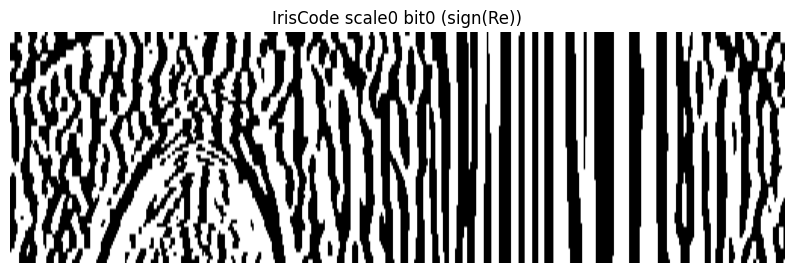

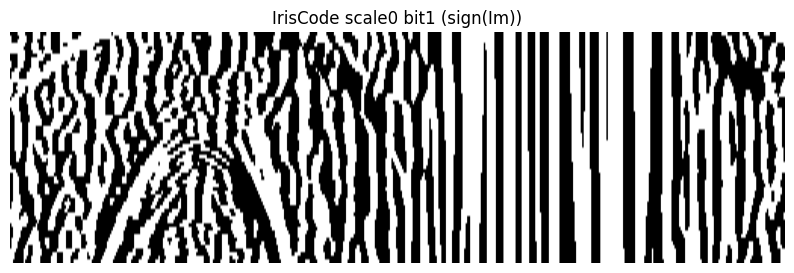

In [ ]:
# =========================
# CELL V8 — IrisCode (Daugman-like): Multi-scale 1D complex Gabor + phase bits
# =========================
import numpy as np
import matplotlib.pyplot as plt

def gabor1d_kernel(length=31, sigma=4.5, freq=0.12):

    if length % 2 == 0:
        length += 1
    half = length // 2
    x = np.arange(-half, half+1, dtype=np.float32)

    gauss = np.exp(-(x*x) / (2*sigma*sigma)).astype(np.float32)
    real = gauss * np.cos(2*np.pi*freq*x).astype(np.float32)
    imag = gauss * np.sin(2*np.pi*freq*x).astype(np.float32)

    # zero-mean real part helps reduce DC sensitivity
    real = real - real.mean()
    return real.astype(np.float32), imag.astype(np.float32)

def conv_circular_1d(signal, kernel):

    A = signal.shape[0]
    K = kernel.shape[0]
    half = K // 2
    out = np.zeros((A,), dtype=np.float32)
    for k in range(K):
        shift = k - half
        out += kernel[k] * np.roll(signal, -shift)
    return out

def iriscode_from_norm_multiscale(norm, mask_norm, params):

    R, A = norm.shape
    S = len(params)

    code = np.zeros((R, A, 2*S), dtype=np.uint8)
    maskb = np.zeros((R, A, 2*S), dtype=np.uint8)

    # ensure mask is 0/1
    mrow = mask_norm.astype(np.uint8)

    for si, p in enumerate(params):
        kr, ki = gabor1d_kernel(length=p["klen"], sigma=p["sigma"], freq=p["freq"])

        for r in range(R):
            row = norm[r].astype(np.float32)

            re = conv_circular_1d(row, kr)
            im = conv_circular_1d(row, ki)

            code[r, :, 2*si + 0] = (re >= 0).astype(np.uint8)
            code[r, :, 2*si + 1] = (im >= 0).astype(np.uint8)

            maskb[r, :, 2*si + 0] = mrow[r]
            maskb[r, :, 2*si + 1] = mrow[r]

    return code, maskb

def column_gating(mask_norm, min_col_valid=0.35, min_run=8):

    R, A = mask_norm.shape
    col_ratio = mask_norm.mean(axis=0)
    good = (col_ratio >= float(min_col_valid))

    if min_run and min_run > 1:
        good2 = good.copy()
        i = 0
        while i < A:
            if not good[i]:
                i += 1
                continue
            j = i
            while j < A and good[j]:
                j += 1
            if (j - i) < int(min_run):
                good2[i:j] = False
            i = j
        good = good2

    gated = (mask_norm * good[None, :]).astype(np.uint8)
    return gated, col_ratio

# ---- Quick test on 1 sample (end-to-end: norm -> adaptive mask -> gating -> iriscode) ----
b = next(iter(ver_loader))
preds = infer_batch_circles(model_iln, model_prn, b, roi_scale=4.0)

img0 = b["image"][0]
pupil0 = preds[0]["pupil_refined"]
iris0  = preds[0]["iris"]

norm0, _, _ = rubber_sheet_normalize_ray(img0, pupil0, iris0, r_min=0.02, r_max=0.98)


mask0, meta0 = build_mask_norm_adaptive(
    norm0,
    top_frac=0.12, bot_frac=0.12,
    hi_q=99.0, lo_q=1.0,
    hi_cap=0.985, lo_cap=0.15,
    use_iqr=True, iqr_k=1.5, iqr_axis="col",
    use_texture=False
)


mask0_gated, col_ratio0 = column_gating(mask0, min_col_valid=0.35, min_run=8)

# Multi-scale params (2 scales = 4 bits per pixel)
PARAMS = [
    {"klen": 31, "sigma": 4.5, "freq": 0.10},
    {"klen": 31, "sigma": 4.5, "freq": 0.18},
]

code0, maskb0 = iriscode_from_norm_multiscale(norm0, mask0_gated, PARAMS)

print("valid_ratio mask:", float(mask0.mean()))
print("valid_ratio gated:", float(mask0_gated.mean()))
print("valid bits ratio:", float(maskb0.mean()))
print("code:", code0.shape, "maskb:", maskb0.shape)


plt.figure(figsize=(10,3))
plt.imshow(code0[:, :, 0], cmap="gray", aspect="auto")
plt.title("IrisCode scale0 bit0 (sign(Re))")
plt.axis("off")
plt.show()

plt.figure(figsize=(10,3))
plt.imshow(code0[:, :, 1], cmap="gray", aspect="auto")
plt.title("IrisCode scale0 bit1 (sign(Im))")
plt.axis("off")
plt.show()


Geometry gating (soft sanity check)

The goal is to discard clearly implausible pupil–iris configurations before matching. I apply a few loose geometric constraints on sizes and relative alignment, limiting how far the iris center can drift from the pupil, to remove obvious failures without hurting valid samples.

In [ ]:
# =========================
# CELL — Geometry gating (SOFT+) tuned from diagnostics
# =========================
import numpy as np
from collections import Counter

def geometry_stats(pupil, iris):
    xp, yp, rp = pupil
    xi, yi, ri = iris
    d = float(np.hypot(xi - xp, yi - yp))
    return {
        "rp": float(rp),
        "ri": float(ri),
        "ri_rp": float(ri / (rp + 1e-6)),
        "center_dist": d,
        "center_dist_ri": float(d / (ri + 1e-6)),
    }

def pass_geometry_gate_softplus(pupil, iris,
                                # keep other constraints very loose:
                                rp_min=18, rp_max=140,
                                ri_min=55, ri_max=280,
                                ri_rp_min=1.8, ri_rp_max=6.2,
                                # ONLY tightened based on your diagnostic table:
                                center_dist_ri_max=0.25):

    g = geometry_stats(pupil, iris)

    if g["rp"] < rp_min or g["rp"] > rp_max:
        return False, "rp_out"
    if g["ri"] < ri_min or g["ri"] > ri_max:
        return False, "ri_out"
    if g["ri_rp"] < ri_rp_min or g["ri_rp"] > ri_rp_max:
        return False, "ri_rp_out"
    if g["center_dist_ri"] > center_dist_ri_max:
        return False, "center_off"

    return True, "ok"

# reset counters each run
geo_reject_counter = Counter()


In [ ]:
# =========================
# CELL V8.9 — Build templates (loop over dataset)
# =========================
from tqdm import tqdm
import numpy as np

# ---- settings ----
MAX_TEMPLATES = None
MIN_VALID_RATIO = 0.20
MIN_BITS = 2000

# multi-scale params (V8 multi-scale)
PARAMS = [
    {"klen": 31, "sigma": 4.5, "freq": 0.08},
    {"klen": 31, "sigma": 4.5, "freq": 0.14},
    {"klen": 31, "sigma": 4.5, "freq": 0.20},
]

templates = []
skipped = 0
nvalid_list = []

pbar = tqdm(ver_loader, total=len(ver_loader))
for batch in pbar:
    preds = infer_batch_circles(model_iln, model_prn, batch, roi_scale=4.0)

    B = batch["image"].shape[0]
    for i in range(B):
        sid = batch["sid"][i]
        fn  = batch["filename"][i]
        img = batch["image"][i]  # torch (1,480,640)

        pupil = preds[i]["pupil_refined"]
        iris  = preds[i]["iris"]

        # --- geometry gating (soft) ---
        ok_geo, reason = pass_geometry_gate_softplus(pupil, iris, center_dist_ri_max=0.25)

        if not ok_geo:
            geo_reject_counter[reason] += 1
            skipped += 1
            continue

        # --- normalization (keep in [0,1]) ---
        try:
            norm01, _, _ = rubber_sheet_normalize_ray(img, pupil, iris, r_min=0.02, r_max=0.98)
        except Exception:
            skipped += 1
            continue

        # --- mask built on norm01 ---
        mask0, meta0 = build_mask_norm_adaptive(
            norm01,
            top_frac=0.12, bot_frac=0.12,
            hi_q=99.0, lo_q=1.0,
            hi_cap=0.985, lo_cap=0.15,
            use_iqr=True, iqr_k=1.5, iqr_axis="col",
            use_texture=False
        )

        # gate globale “light”
        if float(mask0.mean()) < MIN_VALID_RATIO:
            skipped += 1
            continue

        # --- column gating ---
        mask_gated, col_ratio = column_gating(mask0, min_col_valid=0.50, min_run=12)

        # --- iriscode (multi-scale) computed on norm01 ---
        code, maskb = iriscode_from_norm_multiscale(norm01, mask_gated, PARAMS)

        # quality: bits validi
        n_valid = int(maskb.sum())
        if n_valid < MIN_BITS:
            skipped += 1
            continue

        templates.append({
            "sid": sid,
            "fn": fn,
            "code": code.astype(np.uint8),
            "mask": maskb.astype(np.uint8),
            "n_valid": n_valid
        })
        nvalid_list.append(n_valid)

        if MAX_TEMPLATES is not None and len(templates) >= MAX_TEMPLATES:
            break

    if MAX_TEMPLATES is not None and len(templates) >= MAX_TEMPLATES:
        break

pbar.close()

print("Templates built:", len(templates), "| skipped:", skipped)
if len(templates) > 0:
    print("Example template keys:", templates[0].keys())
    print("Example shapes:", templates[0]["code"].shape, templates[0]["mask"].shape, "| n_valid:", templates[0]["n_valid"])
    print("n_valid mean/median:", float(np.mean(nvalid_list)), float(np.median(nvalid_list)))

print("Geometry rejects:", dict(geo_reject_counter))
print("Total geo rejects:", sum(geo_reject_counter.values()))


100%|██████████| 165/165 [12:33<00:00,  4.56s/it]

Templates built: 1871 | skipped: 765
Example template keys: dict_keys(['sid', 'fn', 'code', 'mask', 'n_valid'])
Example shapes: (64, 512, 6) (64, 512, 6) | n_valid: 143304
n_valid mean/median: 144117.0208444682 144312.0
Geometry rejects: {'ri_rp_out': 87, 'center_off': 678}
Total geo rejects: 765


Templates: 1871
Example template SID: S1001_L
IDs (subject_eye): 371 | IDs (>=2 templates): 336
Genuine L/R mixed pairs: 0 out of 2000
Scores computed: genuine=2000 (skipped 0), impostor=2000 (skipped 0)
Genuine range: (0.2299343696027634, 0.49199639039289184)
Impostor range: (0.4683166914524467, 0.49628530010314736)
AUC: 0.9820
EER: 6.30% at threshold=0.4806 | FAR=6.35% FRR=6.25%


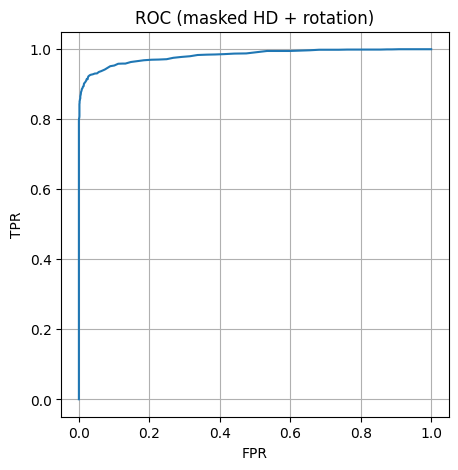

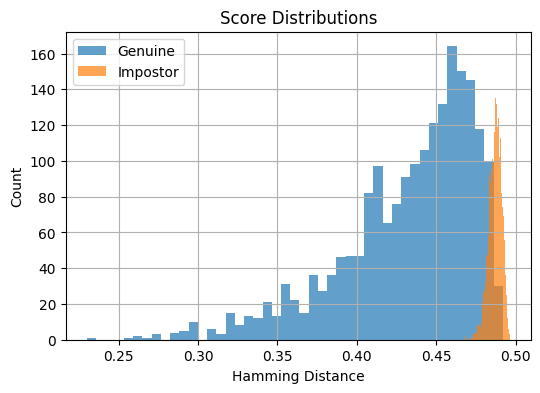

In [ ]:
# =========================
# CELL V9 — Matching (masked HD + rotation) + ROC/AUC/EER
# =========================
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# -------------------------
# Core: rotation + masked HD
# -------------------------
def rotate_template(code, maskb, shift):
    if shift == 0:
        return code, maskb
    return (np.roll(code, shift=shift, axis=1),
            np.roll(maskb, shift=shift, axis=1))

def masked_hamming(code1, mask1, code2, mask2, max_shift=10):
    best_hd = 1.0
    best_shift = 0
    best_n = 0

    c1 = code1.astype(np.uint8)
    m1 = mask1.astype(np.uint8)

    for s in range(-max_shift, max_shift + 1):
        c2s, m2s = rotate_template(code2, mask2, s)
        c2s = c2s.astype(np.uint8)
        m2s = m2s.astype(np.uint8)

        m = (m1 & m2s)
        n = int(m.sum())
        if n == 0:
            continue

        diff = ((c1 ^ c2s) & m)
        hd = float(diff.sum()) / float(n)

        if hd < best_hd:
            best_hd = hd
            best_shift = s
            best_n = n

    return best_hd, best_shift, best_n

# -------------------------
# Pair generation (ALWAYS rebuilt)
# -------------------------
def build_pairs_by_sid(templates_by_sid, n_genuine=2000, n_impostor=2000, seed=42):
    rng = random.Random(seed)
    sids = [sid for sid, lst in templates_by_sid.items() if len(lst) >= 2]
    if len(sids) == 0:
        return [], []

    genuine_pairs = []
    for _ in range(n_genuine):
        sid = rng.choice(sids)
        lst = templates_by_sid[sid]
        i, j = rng.sample(range(len(lst)), 2)
        genuine_pairs.append((lst[i], lst[j]))

    impostor_pairs = []
    for _ in range(n_impostor):
        sid1, sid2 = rng.sample(sids, 2)
        impostor_pairs.append((rng.choice(templates_by_sid[sid1]),
                               rng.choice(templates_by_sid[sid2])))

    return genuine_pairs, impostor_pairs

# -------------------------
# ROC / EER
# -------------------------
def roc_far_frr(genuine_scores, impostor_scores, n_thresh=900):
    g = np.array(genuine_scores, dtype=np.float32)
    i = np.array(impostor_scores, dtype=np.float32)
    if len(g) == 0 or len(i) == 0:
        raise ValueError("Empty score lists.")

    mn = float(min(g.min(), i.min()))
    mx = float(max(g.max(), i.max()))
    thresh = np.linspace(mn, mx, n_thresh).astype(np.float32)

    FAR = np.zeros_like(thresh)
    FRR = np.zeros_like(thresh)
    TPR = np.zeros_like(thresh)
    FPR = np.zeros_like(thresh)

    # accept genuine if score <= t
    for k, t in enumerate(thresh):
        FAR[k] = float(np.mean(i <= t))
        FRR[k] = float(np.mean(g > t))
        TPR[k] = 1.0 - FRR[k]
        FPR[k] = FAR[k]

    return thresh, FPR, TPR, FAR, FRR

def auc_trapz(x, y):
    order = np.argsort(x)
    xs = x[order]
    ys = y[order]
    return float(np.trapezoid(ys, xs))  # no deprecation warning

def eer_from_far_frr(thresh, FAR, FRR):
    d = np.abs(FAR - FRR)
    k = int(np.argmin(d))
    eer = float((FAR[k] + FRR[k]) / 2.0)
    return eer, float(thresh[k]), k

# =========================================================
# V9 START: rebuild templates_by_sid from CURRENT templates
# =========================================================
print("Templates:", len(templates))
print("Example template SID:", templates[0]["sid"])

templates_by_sid = defaultdict(list)
for t in templates:
    templates_by_sid[t["sid"]].append(t)

n_ge2 = sum(1 for v in templates_by_sid.values() if len(v) >= 2)
print("IDs (subject_eye):", len(templates_by_sid), "| IDs (>=2 templates):", n_ge2)

# --------- build fresh pairs ----------
N_G = 2000
N_I = 2000
g_pairs, i_pairs = build_pairs_by_sid(templates_by_sid, n_genuine=N_G, n_impostor=N_I, seed=42)

# sanity: genuine must NEVER mix eyes if sid is "Sxxxx_L/R"
bad = 0
for t1, t2 in g_pairs:
    e1 = t1["sid"].split("_")[-1]
    e2 = t2["sid"].split("_")[-1]
    if e1 != e2:
        bad += 1
print("Genuine L/R mixed pairs:", bad, "out of", len(g_pairs))
assert bad == 0, "BUG: genuine pairs are mixing L and R. sid format or pairing is wrong."

# --------- compute scores ----------
MAX_SHIFT = 10         # from your sweep: best around 10
MIN_BITS  = 20000      # stability gate; you have ~140k bits

genuine_scores = []
impostor_scores = []
sk_g = 0
sk_i = 0

for t1, t2 in g_pairs:
    hd, sh, n = masked_hamming(t1["code"], t1["mask"], t2["code"], t2["mask"], max_shift=MAX_SHIFT)
    if n < MIN_BITS:
        sk_g += 1
        continue
    genuine_scores.append(hd)

for t1, t2 in i_pairs:
    hd, sh, n = masked_hamming(t1["code"], t1["mask"], t2["code"], t2["mask"], max_shift=MAX_SHIFT)
    if n < MIN_BITS:
        sk_i += 1
        continue
    impostor_scores.append(hd)

print(f"Scores computed: genuine={len(genuine_scores)} (skipped {sk_g}), impostor={len(impostor_scores)} (skipped {sk_i})")
print("Genuine range:", (min(genuine_scores), max(genuine_scores)) if genuine_scores else None)
print("Impostor range:", (min(impostor_scores), max(impostor_scores)) if impostor_scores else None)

# --------- ROC / EER ----------
thresh, FPR, TPR, FAR, FRR = roc_far_frr(genuine_scores, impostor_scores, n_thresh=900)
auc = auc_trapz(FPR, TPR)
eer, t_eer, k_eer = eer_from_far_frr(thresh, FAR, FRR)

print(f"AUC: {auc:.4f}")
print(f"EER: {eer*100:.2f}% at threshold={t_eer:.4f} | FAR={FAR[k_eer]*100:.2f}% FRR={FRR[k_eer]*100:.2f}%")

# --------- plots ----------
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (masked HD + rotation)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(genuine_scores, bins=45, alpha=0.7, label="Genuine")
plt.hist(impostor_scores, bins=45, alpha=0.7, label="Impostor")
plt.xlabel("Hamming Distance")
plt.ylabel("Count")
plt.title("Score Distributions")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# =========================
#  Operating points (FAR=1%, FAR=0.1%) + FRR/GAR (lecture-style)
# =========================
import numpy as np

# ---- sanity ----
need = ["genuine_scores", "impostor_scores"]
missing = [v for v in need if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Run CELL V9 first.")

g = np.array(genuine_scores, dtype=np.float32)   # genuine distances (smaller = more similar)
i = np.array(impostor_scores, dtype=np.float32)  # impostor distances

if len(g) == 0 or len(i) == 0:
    raise RuntimeError("Empty score arrays. Cannot compute operating points.")

# Accept if score <= t  (distance-based decision)
def rates_at_threshold(t):
    FAR = float(np.mean(i <= t))   # false accept: impostor accepted
    FRR = float(np.mean(g >  t))   # false reject: genuine rejected
    GAR = 1.0 - FRR
    return FAR, FRR, GAR

def threshold_for_far(target_far):
    """
    Choose the smallest threshold t such that FAR(t) <= target_far.
    For distance-based acceptance, FAR increases with t.
    Using quantile gives an operating point on impostor distribution.
    """
    # quantile at target_far: P(impostor <= t) = target_far  => FAR ~ target_far
    t = float(np.quantile(i, target_far))
    # due to discreteness, FAR can be slightly > target_far; adjust downward if needed
    FAR, _, _ = rates_at_threshold(t)
    if FAR > target_far:
        # move slightly left until FAR <= target (use sorted impostor values)
        s = np.sort(i)
        # find last index where FAR <= target
        # FAR at s[k] is (k+1)/N; we want (k+1)/N <= target
        N = len(s)
        k = int(np.floor(target_far * N) - 1)
        k = max(0, min(N-1, k))
        t = float(s[k])
    return t

# ---- compute standard operating points ----
targets = [0.01, 0.001]  # 1%, 0.1%
rows = []

for tfar in targets:
    t = threshold_for_far(tfar)
    FAR, FRR, GAR = rates_at_threshold(t)
    rows.append((tfar, t, FAR, FRR, GAR))

# ---- EER operating point (optional, reusing V9 values if present) ----
eer_info = None
if all(v in globals() for v in ["eer", "t_eer", "FAR", "FRR"]) and (isinstance(t_eer, (float, int))):
    FAR_e, FRR_e, GAR_e = rates_at_threshold(float(t_eer))
    eer_info = (float(t_eer), FAR_e, FRR_e, GAR_e, float(eer))

# ---- print nicely ----
print("\n================ Operating points (verification) ================")
print("Decision rule: ACCEPT if HD <= t  (distance-based)\n")

for tfar, t, FARv, FRRv, GARv in rows:
    print(f"[Target FAR={tfar*100:.3f}%]  threshold t={t:.6f}")
    print(f"  FAR (measured) = {FARv*100:.3f}%")
    print(f"  FRR            = {FRRv*100:.3f}%")
    print(f"  GAR (=1-FRR)    = {GARv*100:.3f}%\n")

if eer_info is not None:
    t, FARv, FRRv, GARv, eerv = eer_info
    print("---------------------------------------------------------------")
    print(f"[EER operating point]  threshold t_eer={t:.6f}")
    print(f"  FAR = {FARv*100:.3f}% | FRR = {FRRv*100:.3f}% | GAR = {GARv*100:.3f}%")
    print(f"  EER (from curve) ≈ {eerv*100:.3f}%")
print("===============================================================\n")



================ Operating points (verification) ================
Decision rule: ACCEPT if HD <= t  (distance-based)

[Target FAR=1.000%]  threshold t=0.475776
  FAR (measured) = 1.000%
  FRR            = 10.950%
  GAR (=1-FRR)    = 89.050%

[Target FAR=0.100%]  threshold t=0.468954
  FAR (measured) = 0.100%
  FRR            = 19.400%
  GAR (=1-FRR)    = 80.600%

---------------------------------------------------------------
[EER operating point]  threshold t_eer=0.480583
  FAR = 6.350% | FRR = 6.250% | GAR = 93.750%
  EER (from curve) ≈ 6.300%



 IDENTIFICATION PIPELINE


From this point, we evaluate the system in the **identification scenario**, using the iris templates built in the previous cells.

The identification is perfmed in Open-set Scenario and Closed-set



**1) Open-set identification (OS01 → …)**  
I first consider the **open-set setting**, where probe samples may belong to subjects **not enrolled** in the gallery.  
This stage focuses on:
- separating **known vs unknown** identities,
- analyzing rejection behavior,
- evaluating identification performance under uncertainty (open-world scenario).

In [ ]:
# =========================
# CELL OS1 — Open-Set split (gallery / probe_known / probe_unknown)
# =========================
import random
from collections import defaultdict
import numpy as np

# ---- config ----
SEED_OS = 42
KNOWN_FRAC = 0.70   # 70% IDs in gallery (KNOWN), 30% IDs as UNKNOWN
MIN_TEMPL_PER_ID = 2  # need >=2 to have 1 enroll + >=1 probe

rng = random.Random(SEED_OS)

# ---- build templates_by_sid ----
templates_by_sid = defaultdict(list)
for t in templates:
    templates_by_sid[t["sid"]].append(t)

# keep only IDs with enough templates
sids_ok = [sid for sid, lst in templates_by_sid.items() if len(lst) >= MIN_TEMPL_PER_ID]
rng.shuffle(sids_ok)

n_known = int(round(KNOWN_FRAC * len(sids_ok)))
known_sids = set(sids_ok[:n_known])
unknown_sids = set(sids_ok[n_known:])

print("Open-set IDs total (>=2 templates):", len(sids_ok))
print("KNOWN IDs (gallery subjects):", len(known_sids))
print("UNKNOWN IDs (not in gallery):", len(unknown_sids))

# ---- build gallery and probes ----
gallery_by_sid = {}        # sid -> template (enroll)
probe_known = []           # list of dict: {sid, t}
probe_unknown = []         # list of dict: {sid, t}

for sid in sids_ok:
    lst = templates_by_sid[sid]
    # deterministic selection per sid
    lst = sorted(lst, key=lambda x: x["fn"])
    enroll = lst[0]
    probes = lst[1:]

    if sid in known_sids:
        gallery_by_sid[sid] = enroll
        for p in probes:
            probe_known.append({"sid": sid, "t": p})
    else:
        # subject not in gallery -> all its samples are unknown probes
        for p in lst:
            probe_unknown.append({"sid": sid, "t": p})

print("\nGallery size:", len(gallery_by_sid))
print("Probe KNOWN:", len(probe_known))
print("Probe UNKNOWN:", len(probe_unknown))

# quick sanity
assert len(gallery_by_sid) > 0, "Gallery is empty."
assert len(probe_known) > 0, "No known probes."
assert len(probe_unknown) > 0, "No unknown probes."


Open-set IDs total (>=2 templates): 336
KNOWN IDs (gallery subjects): 235
UNKNOWN IDs (not in gallery): 101

Gallery size: 235
Probe KNOWN: 1033
Probe UNKNOWN: 568


In [ ]:
# =========================
# CELL OS1.5 — Open-Set scoring (Vectorized cheap Top-K + full matcher)
# =========================
import numpy as np
from tqdm import tqdm

# ---- speed knobs ----
TOPK = 60
CHEAP_STRIDE_THETA = 2
CHEAP_USE_SCALES = None
MAX_SHIFT_OS = globals().get("MAX_SHIFT", 10)

gallery_sids = list(gallery_by_sid.keys())
G = len(gallery_sids)
if G == 0:
    raise RuntimeError("gallery_by_sid is empty. Run OS1 first.")

print(f"[OS1.5] gallery={G} | probe_known={len(probe_known)} | probe_unknown={len(probe_unknown)} | TOPK={TOPK} | stride_theta={CHEAP_STRIDE_THETA} | scales={CHEAP_USE_SCALES} | MAX_SHIFT={MAX_SHIFT_OS}")

def cheap_view(code, mask):
    c = code
    m = mask
    if CHEAP_STRIDE_THETA and CHEAP_STRIDE_THETA > 1:
        c = c[:, ::CHEAP_STRIDE_THETA, :]
        m = m[:, ::CHEAP_STRIDE_THETA, :]
    if CHEAP_USE_SCALES is not None:
        ch_idx = []
        for s in CHEAP_USE_SCALES:
            ch_idx.extend([2*s, 2*s+1])
        c = c[:, :, ch_idx]
        m = m[:, :, ch_idx]
    return c.astype(np.uint8), m.astype(np.uint8)

# ---- stack cheap gallery for vectorized cheap scoring ----
GC = []
GM = []
for sid in gallery_sids:
    gt = gallery_by_sid[sid]
    c, m = cheap_view(gt["code"], gt["mask"])
    GC.append(c)
    GM.append(m)
GC = np.stack(GC, axis=0)  # (G,R,A,C)
GM = np.stack(GM, axis=0)  # (G,R,A,C)

def shortlist_topk_fast(probe_t, topk=TOPK):
    pc, pm = cheap_view(probe_t["code"], probe_t["mask"])  # (R,A,C)
    valid = (GM & pm[None, ...]).astype(np.uint8)          # (G,R,A,C)
    n = valid.sum(axis=(1,2,3)).astype(np.int64)           # (G,)
    n_safe = np.maximum(n, 1)
    diff = ((GC ^ pc[None, ...]) & valid).sum(axis=(1,2,3)).astype(np.int64)
    hd = diff / n_safe
    hd[n == 0] = 1.0

    k = min(int(topk), G)
    idx = np.argpartition(hd, kth=k-1)[:k]
    idx = idx[np.argsort(hd[idx])]
    return [gallery_sids[i] for i in idx]

def best_match_topk(probe_t, cand_sids):
    best_sid = None
    best_hd  = 1e9
    best_sh  = 0
    best_n   = 0
    for sid in cand_sids:
        gt = gallery_by_sid[sid]
        hd, sh, n = masked_hamming(
            probe_t["code"], probe_t["mask"],
            gt["code"], gt["mask"],
            max_shift=MAX_SHIFT_OS
        )
        hd = float(hd)
        if hd < best_hd:
            best_hd, best_sid, best_sh, best_n = hd, sid, int(sh), int(n)
    if best_sid is None:
        return "None", 1.0, 0, 0
    return str(best_sid), float(best_hd), int(best_sh), int(best_n)

# ---- score KNOWN / UNKNOWN ----
known_rows = []  # list of [true, pred, hd]
unk_rows   = []

hit = 0
tot = 0

print("Scoring KNOWN probes vs gallery...")
for item in tqdm(probe_known, total=len(probe_known)):
    true_sid = str(item["sid"])
    cand = shortlist_topk_fast(item["t"], topk=TOPK)

    tot += 1
    if true_sid in cand:
        hit += 1

    pred_sid, best_hd, best_sh, best_n = best_match_topk(item["t"], cand)
    known_rows.append(np.array([true_sid, pred_sid, float(best_hd)], dtype=object))

print("Scoring UNKNOWN probes vs gallery...")
for item in tqdm(probe_unknown, total=len(probe_unknown)):
    true_sid = str(item["sid"])
    cand = shortlist_topk_fast(item["t"], topk=TOPK)
    pred_sid, best_hd, best_sh, best_n = best_match_topk(item["t"], cand)
    unk_rows.append(np.array([true_sid, pred_sid, float(best_hd)], dtype=object))

# ---- deterministic Nx3 arrays (NO 1D surprises) ----
known_best = np.vstack(known_rows).astype(object) if len(known_rows) else np.empty((0,3), dtype=object)
unk_best   = np.vstack(unk_rows).astype(object)   if len(unk_rows)   else np.empty((0,3), dtype=object)

known_hd = known_best[:,2].astype(np.float32) if len(known_best) else np.array([], dtype=np.float32)
unk_hd   = unk_best[:,2].astype(np.float32)   if len(unk_best)   else np.array([], dtype=np.float32)

print("\nRecall@K on KNOWN probes (true ID in shortlist):", f"{(hit/max(1,tot))*100:.2f}%  ({hit}/{tot})")
print("known_best shape:", known_best.shape, "| unk_best shape:", unk_best.shape)
print("Best-HD ranges:")
print("KNOWN probes  : min/max =", float(known_hd.min()), float(known_hd.max()))
print("UNKNOWN probes: min/max =", float(unk_hd.min()), float(unk_hd.max()))

print("\n✅ Now run OS2.")


[OS1.5] gallery=235 | probe_known=1033 | probe_unknown=568 | TOPK=60 | stride_theta=2 | scales=None | MAX_SHIFT=10
Scoring KNOWN probes vs gallery...


100%|██████████| 1033/1033 [09:28<00:00,  1.82it/s]


Scoring UNKNOWN probes vs gallery...


100%|██████████| 568/568 [05:11<00:00,  1.82it/s]


Recall@K on KNOWN probes (true ID in shortlist): 65.44%  (676/1033)
known_best shape: (1033, 3) | unk_best shape: (568, 3)
Best-HD ranges:
KNOWN probes  : min/max = 0.21660102903842926 0.4821436107158661
UNKNOWN probes: min/max = 0.46395760774612427 0.4834139943122864

✅ Now run OS2.


Best-HD ranges:
KNOWN probes  : min/max = 0.21660102903842926 0.4821436107158661 | N = 1033
UNKNOWN probes: min/max = 0.46395760774612427 0.4834139943122864 | N = 568

================ OPEN-SET Operating points ================
Decision: ALARM if bestHD <= t (and assign bestID)
[Target FPIR=1.000%] t=0.466624 | FPIR=1.056% | DIR@1=51.500% | FNIR=48.500%
[Target FPIR=0.100%] t=0.464508 | FPIR=0.176% | DIR@1=50.339% | FNIR=49.661%



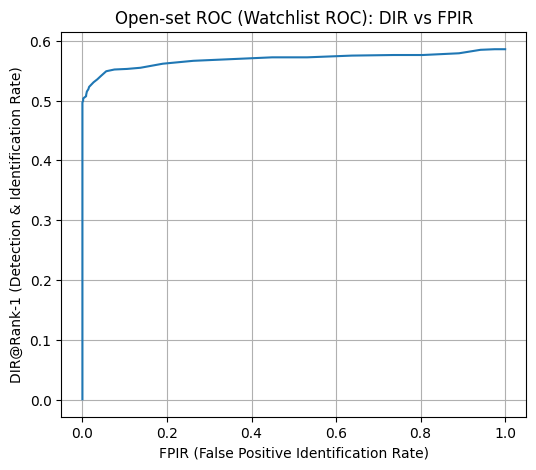

In [ ]:
# =========================
# CELL OS2 — Open-Set metrics/plots (ROBUST + FAST)  [FINAL]
# Requires: known_best, unk_best from OS1.5
# =========================
import numpy as np
import matplotlib.pyplot as plt

assert "known_best" in globals() and "unk_best" in globals(), "Run OS1.5 first"

known_best = np.asarray(known_best, dtype=object)
unk_best   = np.asarray(unk_best, dtype=object)

if known_best.ndim != 2 or known_best.shape[1] < 3:
    raise RuntimeError(f"known_best has shape {known_best.shape}, expected (N,3).")
if unk_best.ndim != 2 or unk_best.shape[1] < 3:
    raise RuntimeError(f"unk_best has shape {unk_best.shape}, expected (N,3).")
if known_best.shape[0] == 0 or unk_best.shape[0] == 0:
    raise RuntimeError(f"Empty arrays: known_best={known_best.shape}, unk_best={unk_best.shape}")

known_true = known_best[:,0].astype(str)
known_pred = known_best[:,1].astype(str)
known_hd   = known_best[:,2].astype(np.float32)
unk_hd     = unk_best[:,2].astype(np.float32)

# filter non-finite
k_ok = np.isfinite(known_hd)
u_ok = np.isfinite(unk_hd)
if not k_ok.all():
    known_true, known_pred, known_hd = known_true[k_ok], known_pred[k_ok], known_hd[k_ok]
if not u_ok.all():
    unk_hd = unk_hd[u_ok]

print("Best-HD ranges:")
print("KNOWN probes  : min/max =", float(known_hd.min()), float(known_hd.max()), "| N =", len(known_hd))
print("UNKNOWN probes: min/max =", float(unk_hd.min()), float(unk_hd.max()), "| N =", len(unk_hd))

mn = float(min(known_hd.min(), unk_hd.min()))
mx = float(max(known_hd.max(), unk_hd.max()))
THR = np.linspace(mn, mx, 400, dtype=np.float32)

# FPIR(t) = P(unk_hd <= t)
FPIR = (unk_hd[None,:] <= THR[:,None]).mean(axis=1).astype(np.float32)

# DIR@Rank1(t) = P(accept & correct ID) on known probes
accept_known = (known_hd[None,:] <= THR[:,None])
correct_id   = (known_true == known_pred)[None,:]
DIR1 = (accept_known & correct_id).mean(axis=1).astype(np.float32)
FNIR = 1.0 - DIR1

def threshold_for_fpir(target):
    return float(np.quantile(unk_hd, target))

def dir_fnir_at_t(t):
    accept = (known_hd <= t)
    corr   = (known_true == known_pred)
    dir1   = float(np.mean(accept & corr))
    fnir   = 1.0 - dir1
    fpir   = float(np.mean(unk_hd <= t))
    return fpir, dir1, fnir

targets = [0.01, 0.001]
print("\n================ OPEN-SET Operating points ================")
print("Decision: ALARM if bestHD <= t (and assign bestID)")
for tar in targets:
    t = threshold_for_fpir(tar)
    fpir, dir1, fnir = dir_fnir_at_t(t)
    print(f"[Target FPIR={tar*100:.3f}%] t={t:.6f} | FPIR={fpir*100:.3f}% | DIR@1={dir1*100:.3f}% | FNIR={fnir*100:.3f}%")
print("===========================================================\n")

plt.figure(figsize=(6,5))
plt.plot(FPIR, DIR1)
plt.xlabel("FPIR (False Positive Identification Rate)")
plt.ylabel("DIR@Rank-1 (Detection & Identification Rate)")
plt.title("Open-set ROC (Watchlist ROC): DIR vs FPIR")
plt.grid(True)
plt.show()


2) Closed-set identification

I  evaluate **closed-set identification**, assuming that each probe belongs to one of the enrolled subjects.  
This stage measures:
- rank-based identification accuracy,
- recognition performance when the true identity is guaranteed to be in the gallery.

In [ ]:
# =========================
# CELL CS1 — Closed-set protocol (1:N): build GALLERY + PROBES
# (quality-based enrollment using n_valid)
# =========================
import random
from collections import defaultdict

# ---- sanity ----
if "templates" not in globals() or len(templates) == 0:
    raise RuntimeError("Missing 'templates'. Run template-building cell first.")

# group templates by identity (sid = subject_eye)
templates_by_sid = defaultdict(list)
for t in templates:
    templates_by_sid[t["sid"]].append(t)

# keep only IDs with >=2 templates (need 1 gallery + >=1 probe)
eligible_sids = [sid for sid, lst in templates_by_sid.items() if len(lst) >= 2]
print("Closed-set eligible IDs (>=2 templates):", len(eligible_sids))

# ---- choose ONE gallery template per sid (best quality), rest are probes ----
gallery_by_sid = {}   # sid -> template (single)
probe_cs = []         # list of {"sid": sid, "t": template}

# (optional) deterministic tie-break if multiple templates have same n_valid
SEED_CS = 42
rng = random.Random(SEED_CS)

def nvalid(t):
    # robust: if missing, treat as 0
    return int(t.get("n_valid", 0))

for sid in eligible_sids:
    lst = templates_by_sid[sid]

    # pick gallery as template with MAX valid bits (more stable enrollment)
    best_nv = max(nvalid(tt) for tt in lst)
    best_cands = [tt for tt in lst if nvalid(tt) == best_nv]
    gallery_t = rng.choice(best_cands)  # reproducible if ties

    gallery_by_sid[sid] = gallery_t

    # rest are probes
    for tt in lst:
        if tt is gallery_t:
            continue
        probe_cs.append({"sid": sid, "t": tt})

print("Gallery size (IDs):", len(gallery_by_sid))
print("Probe size (templates):", len(probe_cs))

# quick peek
ex_sid = eligible_sids[0]
print("Example SID:", ex_sid, "| #templates:", len(templates_by_sid[ex_sid]))
print("Example gallery fn:", gallery_by_sid[ex_sid]["fn"], "| n_valid:", nvalid(gallery_by_sid[ex_sid]))
print("Example probe fn  :", probe_cs[0]["t"]["fn"], "| n_valid:", nvalid(probe_cs[0]["t"]))


Closed-set eligible IDs (>=2 templates): 336
Gallery size (IDs): 336
Probe size (templates): 1500
Example SID: S1001_L | #templates: 3
Example gallery fn: S1001L10.jpg | n_valid: 144756
Example probe fn  : S1001L02.jpg | n_valid: 143304


Gallery IDs = 336 | Probes = 1500 | MAX_SHIFT=10
Mode: TOPK
TOPK=120 | cheap_stride_theta=1 | cheap_scales=[0, 1] | cheap_max_shift=2


Closed-set scoring: 100%|██████████| 1500/1500 [36:18<00:00,  1.45s/it]


================ Closed-set results ================
Rank-1  : 75.13%
Rank-5  : 79.60%
Rank-10 : 82.20%
Recall@K (true in shortlist): 87.93%  (1319/1500)



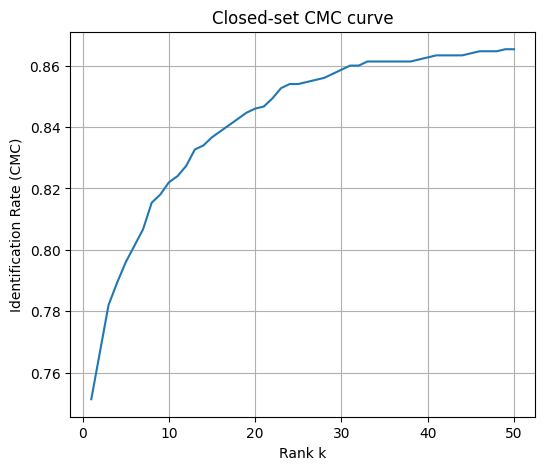

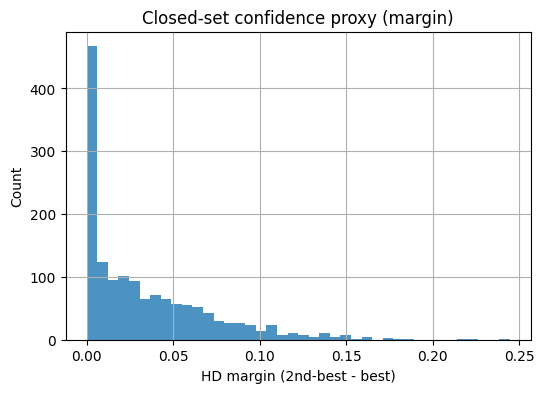

In [ ]:
# =========================
# CELL CS2 — Closed-set (1:N) evaluation: Rank-k + CMC curve
# (IMPROVED TOP-K: cheap micro-shift + less aggressive theta + optional scale subset)
# NOTE: final matcher is unchanged (masked_hamming with MAX_SHIFT_CS)
# =========================
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---- config ----
MAX_SHIFT_CS = globals().get("MAX_SHIFT", 10)

# Speed option
USE_TOPK = True

# TOP-K shortlist size (increase to improve Recall@K)
TOPK_CS = 120

# Cheap prefilter controls (only affect shortlist, NOT final matcher)
CHEAP_STRIDE_THETA = 1        #  1 uses all theta columns (more reliable)
CHEAP_USE_SCALES = [0, 1]     #  use early scales only
CHEAP_MAX_SHIFT = 2           # micro-rotation only in cheap stage )

# ---- sanity ----
if "gallery_by_sid" not in globals() or "probe_cs" not in globals():
    raise RuntimeError("Missing gallery/probe. Run CS1 first.")
if len(probe_cs) == 0:
    raise RuntimeError("Empty probes. Need >=2 templates per ID.")

gallery_sids = list(gallery_by_sid.keys())
G = len(gallery_sids)
print(f"Gallery IDs = {G} | Probes = {len(probe_cs)} | MAX_SHIFT={MAX_SHIFT_CS}")
print(f"Mode: {'TOPK' if USE_TOPK else 'FULL'}")
if USE_TOPK:
    print(f"TOPK={TOPK_CS} | cheap_stride_theta={CHEAP_STRIDE_THETA} | cheap_scales={CHEAP_USE_SCALES} | cheap_max_shift={CHEAP_MAX_SHIFT}")

# ---- cheap view for TOPK ----
def cheap_view(code, mask):
    c = code
    m = mask

    # theta stride
    if CHEAP_STRIDE_THETA and CHEAP_STRIDE_THETA > 1:
        c = c[:, ::CHEAP_STRIDE_THETA, :]
        m = m[:, ::CHEAP_STRIDE_THETA, :]

    # channel subset by scales
    if CHEAP_USE_SCALES is not None:
        ch_idx = []
        for s in CHEAP_USE_SCALES:
            ch_idx.extend([2*s, 2*s + 1])
        c = c[:, :, ch_idx]
        m = m[:, :, ch_idx]

    return c.astype(np.uint8), m.astype(np.uint8)

# ---- cheap masked HD with MICRO-SHIFT (fast) ----
def masked_hamming_cheap(code1, mask1, code2, mask2, max_shift=0):
    """
    Cheap score used ONLY for shortlist retrieval.
    If max_shift>0, does small rotation search to reduce ranking errors due to rotation.
    """
    c1 = code1.astype(np.uint8)
    m1 = mask1.astype(np.uint8)

    best = 1.0
    for s in range(-max_shift, max_shift + 1):
        c2s = np.roll(code2, shift=s, axis=1).astype(np.uint8)
        m2s = np.roll(mask2, shift=s, axis=1).astype(np.uint8)

        m = (m1 & m2s)
        n = int(m.sum())
        if n == 0:
            continue

        diff = ((c1 ^ c2s) & m)
        hd = float(diff.sum()) / float(n)
        if hd < best:
            best = hd
    return best

# precompute cheap gallery once
gallery_cheap = None
if USE_TOPK:
    gallery_cheap = {}
    for sid in gallery_sids:
        gt = gallery_by_sid[sid]
        c, m = cheap_view(gt["code"], gt["mask"])
        gallery_cheap[sid] = (c, m)

def shortlist_topk(probe_t, topk=TOPK_CS):
    pc, pm = cheap_view(probe_t["code"], probe_t["mask"])
    scores = []
    for sid in gallery_sids:
        gc, gm = gallery_cheap[sid]
        hd0 = masked_hamming_cheap(pc, pm, gc, gm, max_shift=CHEAP_MAX_SHIFT)
        scores.append((hd0, sid))
    scores.sort(key=lambda x: x[0])
    return [sid for (_, sid) in scores[:topk]]

# ---- final scorer (TRUE matcher, unchanged) ----
def hd_probe_vs_gallery_full(probe_t, gallery_t):
    hd, sh, n = masked_hamming(
        probe_t["code"], probe_t["mask"],
        gallery_t["code"], gallery_t["mask"],
        max_shift=MAX_SHIFT_CS
    )
    return float(hd)

# ---- compute ranks ----
ranks = []              # rank position of true ID (1 = best)
best_hds = []           # best HD for probe
margin_hds = []         # (2nd-best - best)
hit_topk = 0            # true in shortlist

for item in tqdm(probe_cs, total=len(probe_cs), desc="Closed-set scoring"):
    true_sid = item["sid"]
    probe_t = item["t"]

    # candidate list
    if USE_TOPK:
        cand = shortlist_topk(probe_t, topk=TOPK_CS)
        if true_sid in cand:
            hit_topk += 1
    else:
        cand = gallery_sids

    # full HD for ranking (true matcher)
    scored = []
    for sid in cand:
        gt = gallery_by_sid[sid]
        hd = hd_probe_vs_gallery_full(probe_t, gt)
        scored.append((hd, sid))
    scored.sort(key=lambda x: x[0])

    # rank of true ID
    rank = None
    for k, (_, sid) in enumerate(scored, start=1):
        if sid == true_sid:
            rank = k
            break
    if rank is None:
        rank = TOPK_CS + 1  # miss (true not in shortlist)

    ranks.append(rank)
    best_hds.append(scored[0][0])
    margin_hds.append(scored[1][0] - scored[0][0] if len(scored) >= 2 else np.nan)

ranks = np.array(ranks, dtype=np.int32)
best_hds = np.array(best_hds, dtype=np.float32)
margin_hds = np.array(margin_hds, dtype=np.float32)

# ---- Rank-k metrics ----
def rank_k_acc(k):
    return float(np.mean(ranks <= k))

rank1 = rank_k_acc(1)
rank5 = rank_k_acc(5)
rank10 = rank_k_acc(10)

print("\n================ Closed-set results ================")
print(f"Rank-1  : {rank1*100:.2f}%")
print(f"Rank-5  : {rank5*100:.2f}%")
print(f"Rank-10 : {rank10*100:.2f}%")
if USE_TOPK:
    print(f"Recall@K (true in shortlist): {hit_topk/len(probe_cs)*100:.2f}%  ({hit_topk}/{len(probe_cs)})")
print("====================================================\n")

# ---- CMC curve ----
MAX_R = min(50, max(10, int(np.max(ranks))))
ks = np.arange(1, MAX_R + 1)
cmc = np.array([rank_k_acc(k) for k in ks], dtype=np.float32)

plt.figure(figsize=(6,5))
plt.plot(ks, cmc)
plt.xlabel("Rank k")
plt.ylabel("Identification Rate (CMC)")
plt.title("Closed-set CMC curve")
plt.grid(True)
plt.show()

# ---- confidence proxy: margin distribution ----
plt.figure(figsize=(6,4))
plt.hist(margin_hds[~np.isnan(margin_hds)], bins=40, alpha=0.8)
plt.xlabel("HD margin (2nd-best - best)")
plt.ylabel("Count")
plt.title("Closed-set confidence proxy (margin)")
plt.grid(True)
plt.show()
